In [1]:
#https://www.pyimagesearch.com/2017/02/20/text-skew-correction-opencv-python/
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Functions to print the images
def myImPrt(img):
    tmp_img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(tmp_img)

def myBWImPrt(img):
    plt.imshow(img,cmap='gray')

In [3]:
def bilateralFilter(image, d, sig):
    image = cv2.bilateralFilter(image, d, sig, sig)
    return image

def threshold(image, t):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, image = cv2.threshold(image, t, 255, cv2.THRESH_BINARY_INV)
#     ret, image = cv2.threshold(image, t, 255, cv2.THRESH_BINARY)
    return image

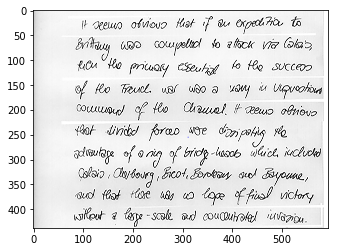

In [4]:
image = cv2.imread('images/new.PNG')
# cv2.imshow('image',image)
myImPrt(image)

In [5]:
TOP_MARGIN = 0.0
LETTER_SIZE = 0.00001
LINE_SPACING = 0.0


In [6]:
''' function to calculate horizontal projection of the image pixel rows and return it '''
def horizontalProjection(img):
    # Return a list containing the sum of the pixels in each row
    (h, w) = img.shape[:2]
    sumRows = []
    for j in range(h):
        row = img[j:j+1, 0:w] # y1:y2, x1:x2
        sumRows.append(np.sum(row))
    return sumRows

In [7]:
img = image.copy()

In [8]:
filtered = bilateralFilter(img, 5, 50)

thresh = threshold(filtered, 127)

# extract a python list containing values of the horizontal projection of the image into 'hp'
hpList = horizontalProjection(thresh)

# Extracting 'Top Margin' feature.
topMarginCount = 0
for sum in hpList:
    # sum can be strictly 0 as well.
    if(sum<=255):
        topMarginCount += 1
    else:
        break


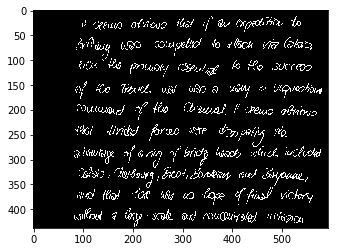

In [9]:
plt.imshow(thresh,cmap='gray')

In [10]:
lineTop = 0
lineBottom = 0
spaceTop = 0
spaceBottom = 0
setLineTop = True
setSpaceTop = True
includeNextSpace = True
space_zero = [] # stores the amount of space between lines
lines = [] # a 2D list storing the vertical start index and end index of each contour

In [11]:
# FIRST we extract the straightened contours from the image by looking at occurance of 0's in the horizontal projection.
# we are scanning the whole horizontal projection now 
for i, sum in enumerate(hpList):
    # sum being 0 means blank space
    if(sum<3000):
        if(setSpaceTop):
            spaceTop = i;
            setSpaceTop = False # spaceTop will be set once for each start of a space between lines
        spaceBottom = i+1;
       
        if(i<len(hpList)-1): # this condition is necessary to avoid array index out of bound error
            if(hpList[i+1]<3000): # if the next horizontal projectin is 0, keep on counting, it's still in blank space
                continue
        # we are using this condition if the previous contour is very thin and possibly not a line
        if(includeNextSpace):
            space_zero.append(spaceBottom-spaceTop)
        else:
            if (len(space_zero)==0):
                previous = 0
            else:
                previous = space_zero.pop()
            space_zero.append(previous + spaceBottom-lineTop)
        setSpaceTop = True # next time we encounter 0, it's begining of another space so we set new spaceTop

    # sum greater than 0 means contour
    if(sum>3000):
        if(setLineTop):
            lineTop = i
            setLineTop = False # lineTop will be set once for each start of a new line/contour
        lineBottom = i+1

        if(i<len(hpList)-1): # this condition is necessary to avoid array index out of bound error
            if(hpList[i+1]>3000): # if the next horizontal projectin is > 0, keep on counting, it's still in contour
                continue

            # if the line/contour is too thin <10 pixels (arbitrary) in height, we ignore it.
            # Also, we add the space following this and this contour itself to the previous space to form a bigger space: spaceBottom-lineTop.
            if(lineBottom-lineTop<20):
                includeNextSpace = False
                setLineTop = True # next time we encounter value > 0, it's begining of another line/contour so we set new lineTop
                continue
        includeNextSpace = True # the line/contour is accepted, new space following it will be accepted

        # append the top and bottom horizontal indices of the line/contour in 'lines'
        lines.append([lineTop, lineBottom])
        setLineTop = True # next time we encounter value > 0, it's begining of another line/contour so we set new lineTop


In [12]:

# Printing the values we found so far.
for i, line in enumerate(lines):
    print()
    print (i)
    print (line[0])
    print (line[1])
    print (len(hpList[line[0]:line[1]]))
    print (hpList[line[0]:line[1]])




0
14
39
25
[4080, 3315, 4080, 4845, 6120, 7650, 11730, 9945, 13260, 16830, 18105, 25755, 26775, 27285, 26775, 28560, 25755, 24990, 21165, 19125, 14535, 11730, 9690, 7650, 3060]

1
57
80
23
[3825, 5355, 6375, 6120, 5865, 7395, 18615, 25500, 31620, 29580, 25755, 24990, 25500, 30090, 32130, 32130, 32895, 33915, 32640, 18615, 11985, 9435, 6885]

2
101
125
24
[3570, 5610, 5610, 5100, 6375, 8415, 9945, 17595, 26010, 28050, 29325, 23715, 23970, 24225, 24225, 29835, 26265, 23460, 21675, 19890, 12750, 10200, 6375, 3570]

3
148
168
20
[3060, 8670, 8160, 11475, 15810, 20400, 23205, 24735, 26265, 29070, 30855, 34170, 34680, 32640, 30855, 27285, 24225, 18615, 12240, 5100]

4
185
212
27
[3315, 4080, 4080, 4080, 6120, 8160, 8670, 9690, 12495, 15300, 19125, 21675, 20910, 25500, 27285, 30090, 31620, 30090, 31365, 32130, 27030, 22950, 16320, 11985, 8925, 6375, 3570]

5
231
256
25
[3315, 3060, 4845, 6375, 7650, 10710, 13005, 17340, 21420, 25500, 28305, 27540, 28050, 26010, 27285, 24735, 25245, 23970, 22

In [ ]:
for i, line in enumerate(lines):
    cv2.imshow("line "+str(i), img[line[0]:line[1], : ])
cv2.waitKey(0)

In [13]:
# LINE SPACING and LETTER SIZE will be extracted here
# We will count the total number of pixel rows containing upper and lower zones of the lines 
# and add the space_zero/runs of 0's(excluding first and last of the list ) to it.
# We will count the total number of pixel rows containing midzones of the lines for letter size.
# For this, we set an arbitrary (yet suitable!) threshold THRESHOLD = 15000 in 
# horizontal projection to identify the midzone containing rows.
# These two total numbers will be divided by number of lines (having at least one row>THRESHOLD) 
# to find average line spacing and average letter size.
THRESHOLD = 15000
new_space_row_count = 0
total_row_count = 0
total_lines_count = 0
flag = False
for i, line in enumerate(lines):
    segment = hpList[line[0]:line[1]]
    for j, sum in enumerate(segment):
        if(sum<THRESHOLD):
            new_space_row_count += 1
        else:
            total_row_count += 1
            flag = True

    # This line has contributed at least one count of pixel row of midzone
    if(flag):
        total_lines_count += 1
        flag = False

In [14]:
# error prevention
if(total_lines_count == 0): total_lines_count = 1

total_space_row_count = new_space_row_count + np.sum(space_zero[1:-1]) #excluding first and last entries: Top and Bottom margins
# the number of spaces is 1 less than number of lines but total_space_row_count contains the top and bottom spaces of the line
average_line_spacing = float(total_space_row_count) / total_lines_count 
average_letter_size = float(total_row_count) / total_lines_count
# letter size is actually height of the letter and we are not considering width
LETTER_SIZE = average_letter_size
# error prevention 
if(average_letter_size == 0): average_letter_size = 1
# We can't just take the average_line_spacing as a feature directly. We must take the average_line_spacing relative to average_letter_size.
# Let's take the ratio of average_line_spacing to average_letter_size as the LINE SPACING, which is perspective to average_letter_size.
relative_line_spacing = average_line_spacing / average_letter_size
LINE_SPACING = relative_line_spacing

# Top marging is also taken relative to average letter size of the handwritting
# relative_top_margin = float(topMarginCount) / average_letter_size
# TOP_MARGIN = relative_top_margin


In [15]:
print(space_zero)
print(lines)
print(total_row_count)
print(total_space_row_count)
print(len(hpList))
print(total_lines_count)
print(i)
print("Average Line Spacing: "+ str(average_line_spacing))
print ("Average letter size: "+ str(average_letter_size))
# print ("Top margin relative to average letter size: "+str(relative_top_margin))
print("Average line spacing relative to \naverage letter size: "+str(relative_line_spacing)) 


[14, 18, 21, 23, 17, 19, 17, 14, 16, 19, 11]
[[14, 39], [57, 80], [101, 125], [148, 168], [185, 212], [231, 256], [273, 301], [315, 342], [358, 382], [401, 427]]
132
281
438
10
9
Average Line Spacing: 28.1
Average letter size: 13.2
Average line spacing relative to 
average letter size: 2.128787878787879
